# Trabajo Práctico 2: Análisis con Redes Neuronales - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

In [5]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

Además, declaramos la función para plotear la pérdida durante el entrenamiento de la red:

In [6]:
def graficar_perdida_modelo(history):
    plt.figure(dpi=125, figsize=(7, 2))
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.title('Loss del modelo')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [7]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de train_test y holdout.

In [8]:
X, y = dividir_dataset(df)
X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros, que son el optimizador y la cantidad de epochs, mediante la siguiente función de búsqueda, que utiliza Stratified K-folds cross validation para comparar cada combinación y así obtener la mejor. Nos quedamos con la combinación cuya media de los k-folds(5) tenga la mejor métrica. Para los optimizadores, utilizamos Adam y SGD con distintos learning rates. La métrica de comparación utilizada es AUC-ROC.

In [9]:
def definir_mejores_hiperparametros(X, y, modelo):
    optimizadores = [keras.optimizers.Adam(learning_rate=0.00001), keras.optimizers.Adam(learning_rate=0.0001), 
                     keras.optimizers.Adam(learning_rate=0.001), keras.optimizers.SGD(learning_rate=0.00001), 
                     keras.optimizers.SGD(learning_rate=0.0001), keras.optimizers.SGD(learning_rate=0.001)]
    params = {'epochs' : [100, 250, 500], 'optimizer' : optimizadores}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=5, cv=5, verbose=0).fit(X, y)    
    return grid_search.best_params_

## Entrenamiento y predicción con el dataset original
Definimos la función para crear la red neuronal, con una capa de 13 neuronas (equivalente a la cantidad de features) de input, y función de activación 'tanh'. También hay una capa oculta de 8 neuronas, con activación 'tanh'. Agregamos capas de Dropout para regularizar la red, además de regularización L2. La capa de salida tiene función de activación sigmoide, con 1 neurona. En cuanto a la función de pérdida, utilizamos binary crossentropy ya que es una clasificación binaria.

In [10]:
def crear_red(optimizer='adam'):
    red_neuronal = Sequential()
    red_neuronal.add(Dense(13, input_dim=50, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(8, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
    red_neuronal.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[keras.metrics.AUC()])
    return red_neuronal

Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier

In [12]:
mejor_combinacion = definir_mejores_hiperparametros(X_train_test, y_train_test, KerasClassifier(build_fn=crear_red, verbose=0))

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [23]:
mejor_optimizador = mejor_combinacion['optimizer']
mejor_cant_epochs = mejor_combinacion['epochs']

nombre_mejor_optimizador = mejor_optimizador.get_config()['name']
mejor_lr = mejor_optimizador.get_config()['learning_rate']
print(f'Mejor optimizador: {nombre_mejor_optimizador} con learning rate {mejor_lr}')
print(f'Mejor cantidad de epochs: {mejor_cant_epochs}')

Mejor optimizador: Adam con learning rate 1e-05
Mejor cantidad de epochs: 500


Creamos la red y la entrenamos con esa combinación. El modelo necesita los labels en one hot encoding, por lo que usamos la función to_categorical para transformarlos:

In [24]:
y_train_test = keras.utils.to_categorical(y_train_test, 2)
y_holdout = keras.utils.to_categorical(y_holdout, 2)

In [25]:
red_neuronal = crear_red(mejor_optimizador)
red_neuronal.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 13)                663       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 112       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 784
Trainable params: 784
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = red_neuronal.fit(
    X_train_test.values, y_train_test.argmax(axis=1), epochs=mejor_cant_epochs, 
    validation_data=(X_holdout.values, y_holdout.argmax(axis=1)), verbose=0
)

Y realizamos la predicción sobre los datos de holdout:

In [27]:
y_pred = red_neuronal.predict(X_holdout)

Mostramos el gráfico de la ROC curve con su respectivo score en la métrica AUC-ROC:

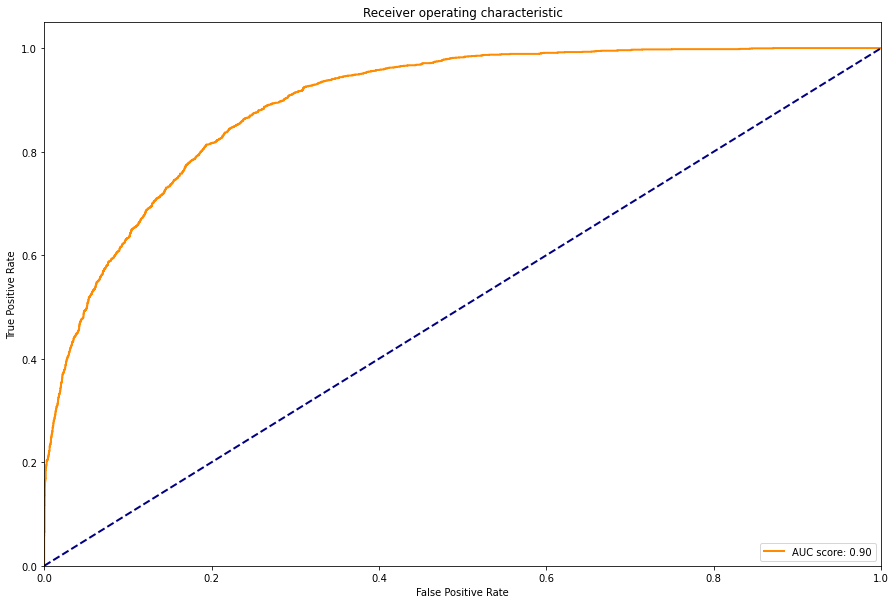

El valor de la metrica AUC-ROC para este modelo es: 0.8957995453479888


In [28]:
graficar_auc_roc(y_holdout.argmax(axis=1), y_pred)

Se puede ver un score muy alto para la red, prácticamente 0.90

Luego, graficamos la pérdida del modelo a lo largo de los epochs, tanto de training como de validation:

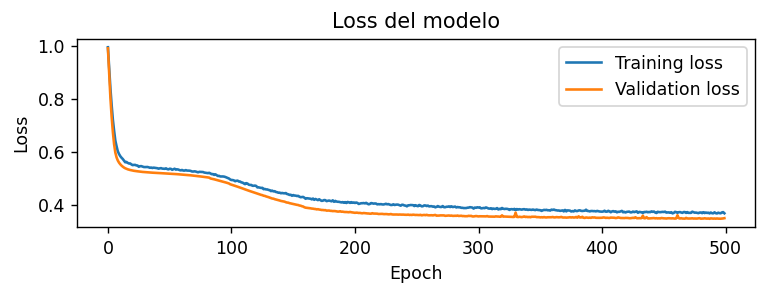

In [29]:
graficar_perdida_modelo(history)

Vemos que las pérdidas de validation y training van prácticamente a la par. Esto tiene sentido, ya que utilizamos dos métodos de regularización para evitar el overfitting (L2 y capas de Dropout). Además, se puede ver que la pérdida desciende de forma suave y sin muchas fluctuaciones, lo que quiere decir que el learning rate está en un valor adecuado, ya que no está muy alto.

A continuación, imprimimos el classification report correspondiente.

In [30]:
print(classification_report(y_holdout.argmax(axis=1), y_pred.round(), target_names=['No Tiene Alto Valor Adquisitivo','Tiene Alto Valor Adquisitivo'], digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.875     0.923     0.899      6181
   Tiene Alto Valor Adquisitivo      0.708     0.586     0.641      1960

                       accuracy                          0.842      8141
                      macro avg      0.792     0.755     0.770      8141
                   weighted avg      0.835     0.842     0.837      8141



Por último, mostramos la matriz de confusión correspondiente:

In [31]:
from funciones_auxiliares import graficar_matriz_confusion

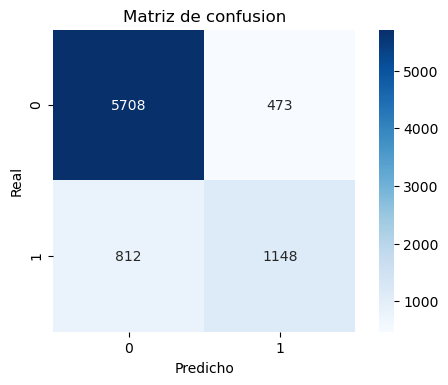

In [32]:
graficar_matriz_confusion(y_holdout.argmax(axis=1), y_pred.round())

Se puede observar un muy buen f1-score para las instancias de bajo valor adquisitivo, se podría decir que las clasifica bastante bien. Por otra parte, para las instancias de altos ingresos, se puede ver una precision relativamente alta (0.71) en comparación a otros modelos, pero un recall regular. 

Cabe destacar que la red tiene una tendencia a predecir instancias de bajo valor adquisitivo. Esto se puede ver en la matriz, ya que predijo más del 40% de las instancias de alto valor como de bajo valor.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados.

Definimos la función para crear la red neuronal, esta vez con una capa de input de 17 neuronas, que equivale a la cantidad de features del dataset expandido mediante clustering.

In [33]:
def crear_red_exp(optimizer='adam'):
    red_neuronal_exp = Sequential()
    red_neuronal_exp.add(Dense(17, input_dim=54, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal_exp.add(Dropout(0.25))
    red_neuronal_exp.add(Dense(8, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal_exp.add(Dropout(0.25))
    red_neuronal_exp.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
    red_neuronal_exp.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[keras.metrics.AUC()])
    return red_neuronal_exp

Expandimos el dataset y realizamos el split del mismo en los subsets de train_test y holdout.

In [34]:
from preprocessing import expandir_dataset

In [35]:
X_exp = expandir_dataset(X)
X_exp_train_test, X_exp_holdout, y_exp_train_test, y_exp_holdout = train_test_split(X_exp, y, test_size=0.25, random_state=0, stratify=y)

Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [36]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp_train_test, y_exp_train_test, KerasClassifier(build_fn=crear_red_exp, verbose=0))

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [37]:
mejor_optimizador = mejor_combinacion['optimizer']
mejor_cant_epochs = mejor_combinacion['epochs']

nombre_mejor_optimizador = mejor_optimizador.get_config()['name']
mejor_lr = mejor_optimizador.get_config()['learning_rate']
print(f'Mejor optimizador: {nombre_mejor_optimizador} con learning rate {mejor_lr}')
print(f'Mejor cantidad de epochs: {mejor_cant_epochs}')

Mejor optimizador: Adam con learning rate 1e-05
Mejor cantidad de epochs: 500


El modelo necesita los labels en one hot encoding, por lo que usamos la función to_categorical para transformarlos:

In [38]:
y_exp_train_test = keras.utils.to_categorical(y_exp_train_test, 2)
y_exp_holdout = keras.utils.to_categorical(y_exp_holdout, 2)

Creamos la red neuronal e imprimimos el resumen:

In [39]:
red_neuronal_exp = crear_red_exp(mejor_optimizador)
red_neuronal_exp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 17)                935       
_________________________________________________________________
dropout_6 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 144       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,088
Trainable params: 1,088
Non-trainable params: 0
_________________________________________________________________


Entrenamos la red con la mejor combinación:

In [40]:
history = red_neuronal_exp.fit(
    X_exp_train_test.values, y_exp_train_test.argmax(axis=1), epochs=mejor_cant_epochs, 
    validation_data=(X_exp_holdout.values, y_exp_holdout.argmax(axis=1)), verbose=0
)

Y realizamos la predicción sobre los datos de holdout:

In [41]:
y_pred = red_neuronal_exp.predict(X_exp_holdout)

Mostramos el gráfico de la ROC curve con su respectivo score en la métrica AUC-ROC:

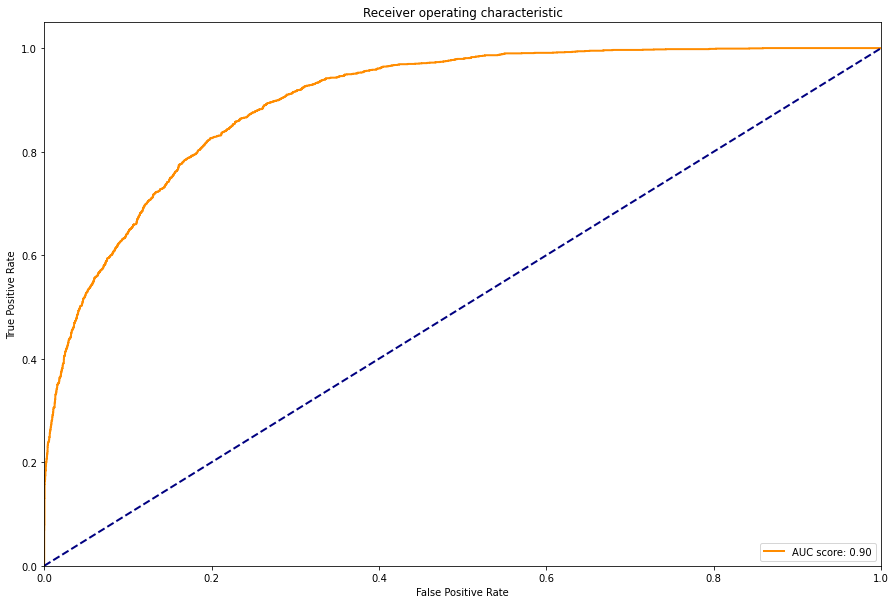

El valor de la metrica AUC-ROC para este modelo es: 0.8997342497911639


In [42]:
graficar_auc_roc(y_exp_holdout.argmax(axis=1), y_pred)

Se puede ver un AUC score prácticamente idéntico al del que se obtuvo con el dataset original.

Luego, graficamos la pérdida del modelo a lo largo de los epochs, tanto de training como de validation:

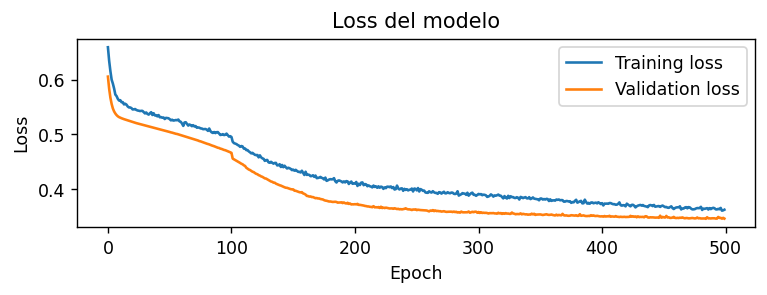

In [43]:
graficar_perdida_modelo(history)

Se puede observar que las pérdidas en los subsets de training y validation son similares, aunque ligeramente distanciadas. Tampoco se ven fluctuaciones muy fuertes en este caso.

A continuación, imprimimos el classification report correspondiente.

In [44]:
print(classification_report(y_exp_holdout.argmax(axis=1), y_pred.round(), target_names=['No Tiene Alto Valor Adquisitivo','Tiene Alto Valor Adquisitivo'], digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.876     0.926     0.901      6181
   Tiene Alto Valor Adquisitivo      0.716     0.588     0.646      1960

                       accuracy                          0.845      8141
                      macro avg      0.796     0.757     0.773      8141
                   weighted avg      0.838     0.845     0.839      8141



Por último, mostramos la matriz de confusión correspondiente:

In [45]:
from funciones_auxiliares import graficar_matriz_confusion

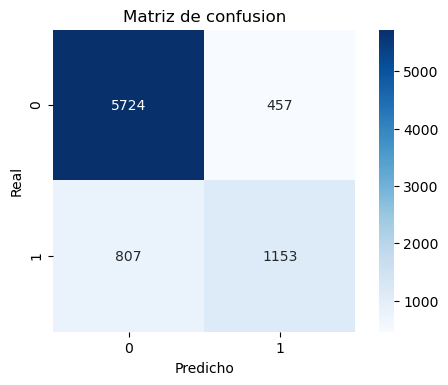

In [46]:
graficar_matriz_confusion(y_exp_holdout.argmax(axis=1), y_pred.round())

Vemos un muy ligero aumento en la precision y recall para las instancias que tienen alto valor adquisitivo, respecto al modelo prediciendo sobre el dataset original. El f1-score para los de bajos ingresos se mantiene prácticamente igual, aumentando muy poco.

Se puede ver que sigue presente la tendencia del modelo a predecir instancias como de bajo valor adquisitivo.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con la red neuronal con el dataset expandido sobre el dataset de predicciones nuevo, y la escribimos al archivo 'RedesNeuronales.csv'

In [47]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [48]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
df_predicciones = expandir_dataset(df_predicciones)

In [49]:
predicciones = red_neuronal_exp.predict(df_predicciones)
escribir_predicciones(ids, predicciones.flatten().round().astype(int), "RedesNeuronales")